In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

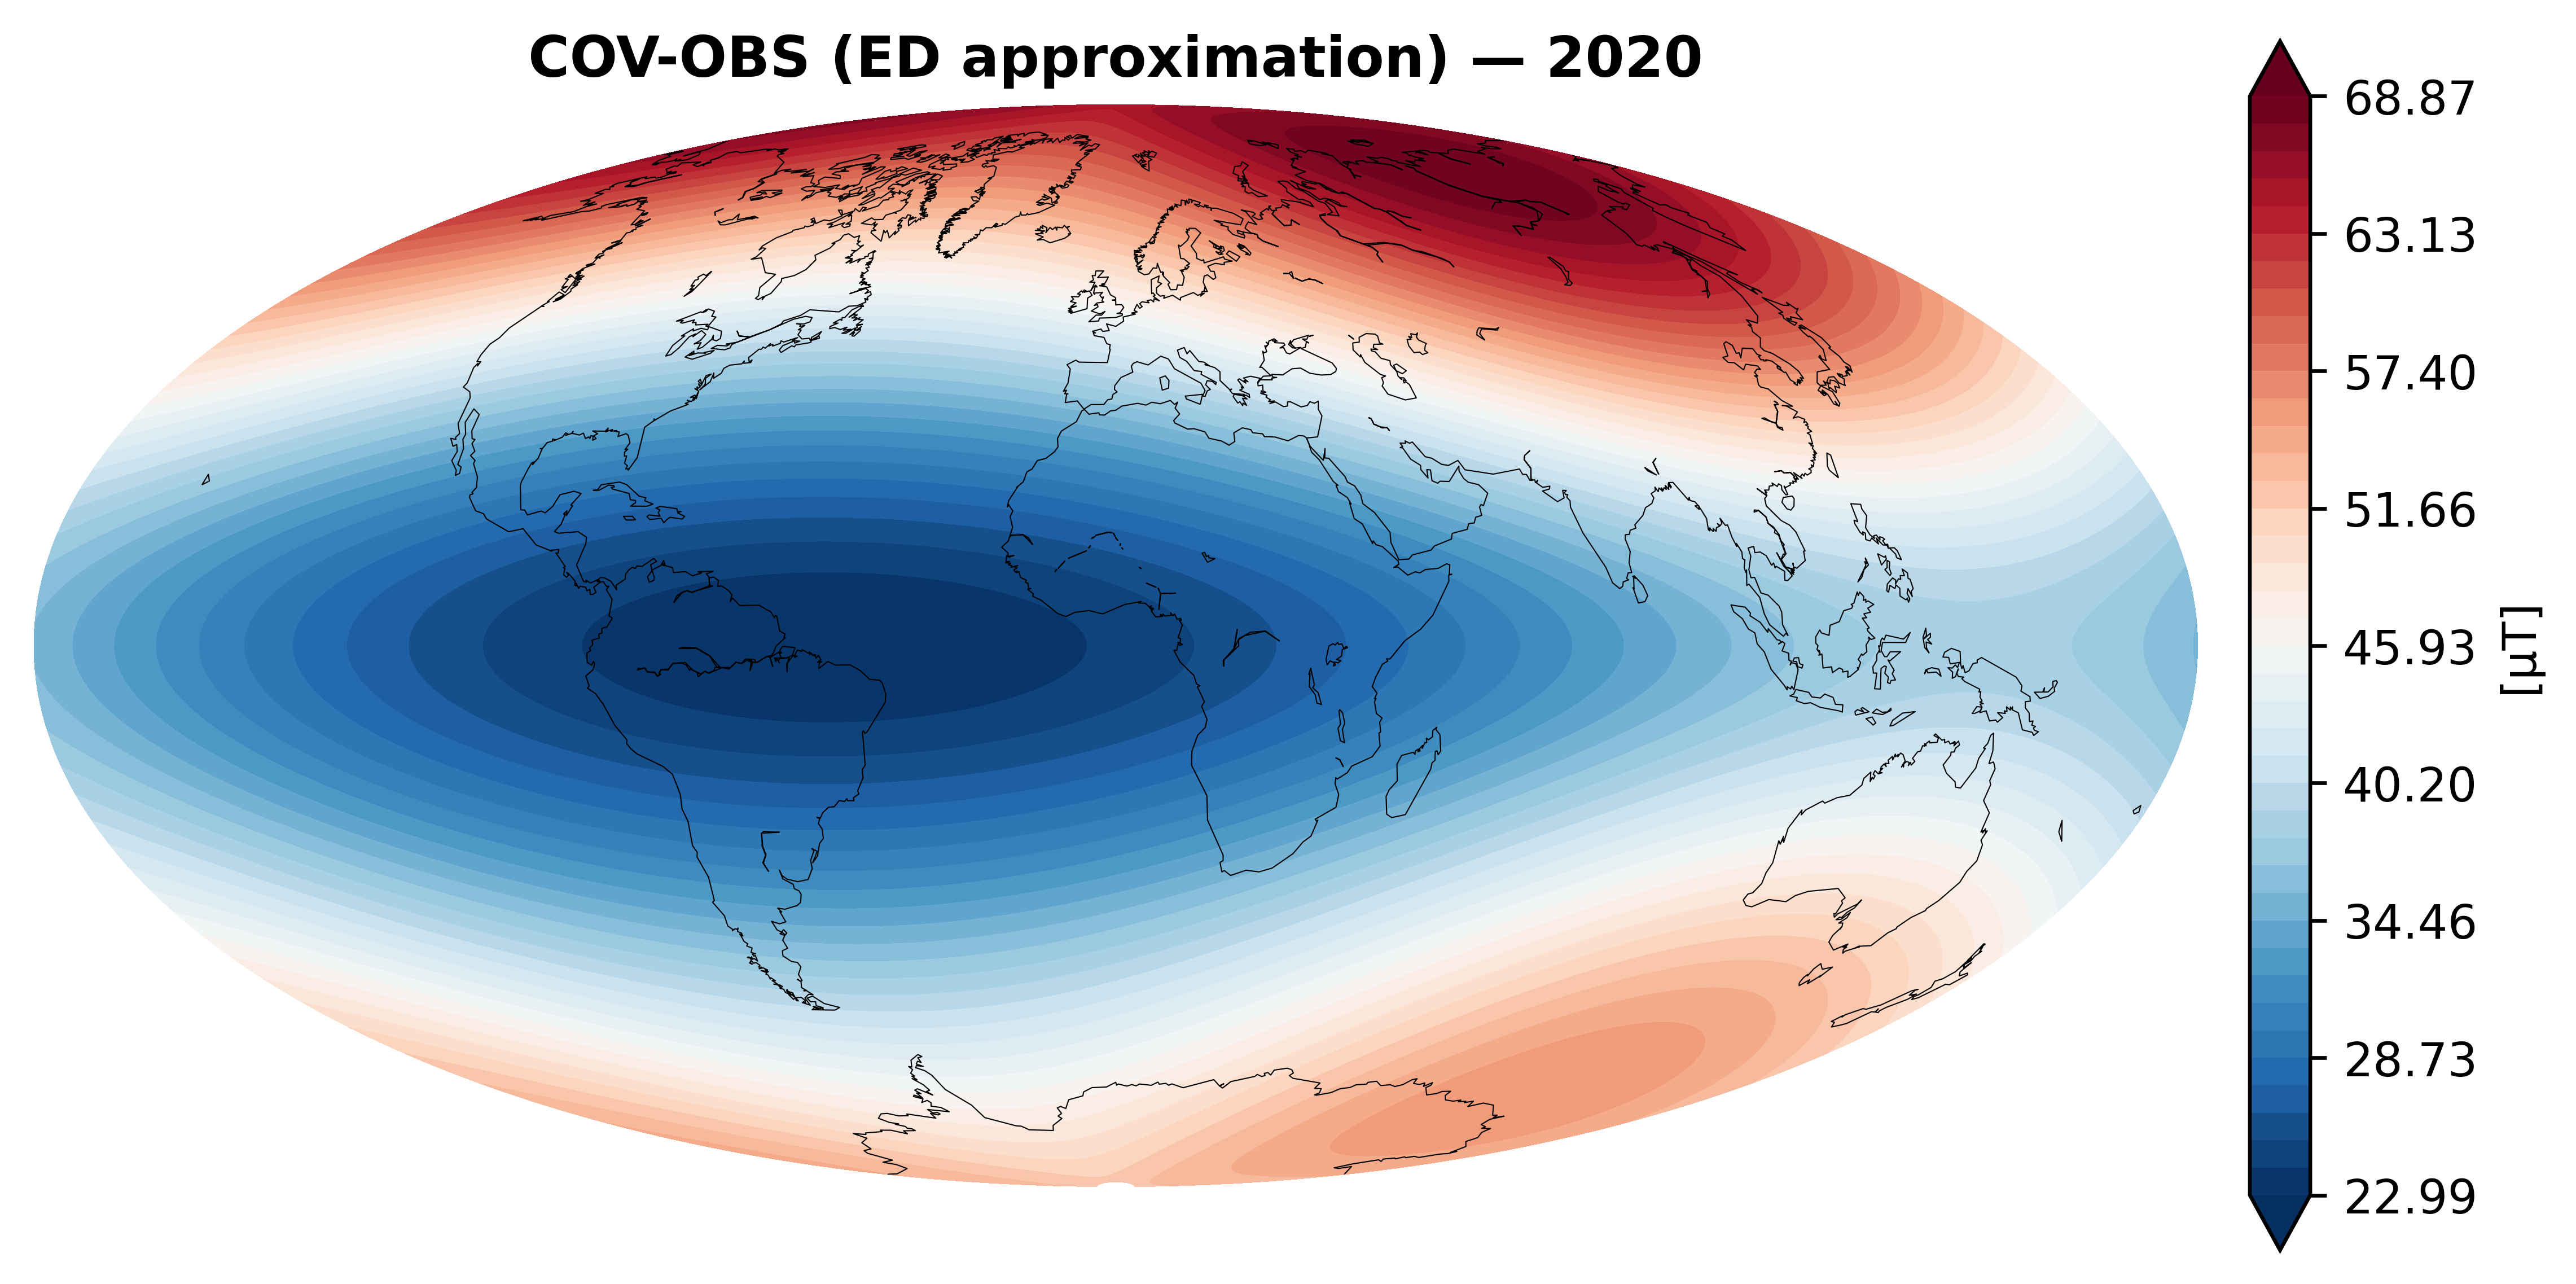

In [2]:
filepath = r"C:/Users/Victor/Desktop/Simulacoes_Diversas/COV-OBS.x2/covobsx2.txt"

year = 2020 # define the year based on the COV-OBS.x2 interval (1840 - 2020)
radius = 6371.2 # radius of our beautiful planet

def read_gauss_coeffs(filename, target_year, lmax=2):
    with open(filename, "r") as f:
        lines = f.readlines()

    years = list(map(lambda x: int(float(x)), lines[0].strip().split()))
    if target_year not in years:
        raise ValueError(f"Year {target_year} is not available in the file :(")
    idx = years.index(target_year)

    coeff_lines = lines[1:]
    coeffs = [list(map(float, line.strip().split())) for line in coeff_lines]
    coeffs_at_year = [row[idx] for row in coeffs]

    gsh, hsh = [], []
    i = 0
    for l in range(1, lmax + 1):
        for m in range(0, l + 1):
            gsh.append(coeffs_at_year[i]); i += 1
            hsh.append(0.0 if m == 0 else coeffs_at_year[i])
            if m != 0:
                i += 1
    return np.array(gsh, dtype=float), np.array(hsh, dtype=float)

def idx_lm(l, m):
    return sum((L + 1) for L in range(1, l)) + m

def F_ED_direct(lat_deg, lon_deg, gsh, hsh, RE=6371.2):
    g10 = gsh[idx_lm(1,0)]; g11 = gsh[idx_lm(1,1)]; h11 = hsh[idx_lm(1,1)]
    g20 = gsh[idx_lm(2,0)]; g21 = gsh[idx_lm(2,1)]; g22 = gsh[idx_lm(2,2)]
    h21 = hsh[idx_lm(2,1)]; h22 = hsh[idx_lm(2,2)]

    L0 = 2*g10*g20 + np.sqrt(3.0)*(g11*g21 + h11*h21)
    L1 = -g11*g20 + np.sqrt(3.0)*(g10*g21 + g11*g22 + h11*h22)
    L2 = -h11*g20 + np.sqrt(3.0)*(g10*h21 - h11*g22 + g11*h22)

    B0 = np.sqrt(g10**2 + g11**2 + h11**2)
    E  = (L0*g10 + L1*g11 + L2*h11) / (4 * B0**2)
    eps  = (L0 - g10*E) / (3 * B0**2)
    eta  = (L1 - g11*E) / (3 * B0**2)
    zeta = (L2 - h11*E) / (3 * B0**2)

    theta = np.radians(90.0 - lat_deg)
    phi   = np.radians(lon_deg)

    px = RE*np.sin(theta)*np.cos(phi)
    py = RE*np.sin(theta)*np.sin(phi)
    pz = RE*np.cos(theta)

    dx, dy, dz = eta*RE, zeta*RE, eps*RE
    px_p, py_p, pz_p = px - dx, py - dy, pz - dz

    rprime = np.sqrt(px_p**2 + py_p**2 + pz_p**2)
    s = np.clip(pz_p / rprime, -1.0, 1.0)
    theta_p = np.arccos(s)
    lat_p = np.radians(90.0) - theta_p

    s2 = np.sin(lat_p)**2
    F_ed = ((RE / rprime)**3 * g10 * np.sqrt(3*s2 + 1.0)) / 1000.0
    return np.abs(F_ed)

gsh_ed, hsh_ed = read_gauss_coeffs(filepath, year, lmax=2)

lon = np.arange(-180, 181, 1)
lat = np.arange(-89,  91, 1)
lon2d, lat2d = np.meshgrid(lon, lat)

F_ed_map = np.zeros_like(lon2d, dtype=float)
for i in range(lat2d.shape[0]):
    for j in range(lat2d.shape[1]):
        F_ed_map[i, j] = F_ED_direct(lat2d[i, j], lon2d[i, j], gsh_ed, hsh_ed, RE=radius)

fig = plt.figure(figsize=(8, 4.5), dpi=600)
ax = plt.gca()

m = Basemap(projection="hammer", lon_0=0, ax=ax)
x, y = m(lon2d, lat2d)

levels = np.linspace(np.nanmin(F_ed_map), np.nanmax(F_ed_map), 41)
cs = ax.contourf(x, y, F_ed_map, levels=levels, cmap="RdBu_r", extend="both")

m.drawmapboundary(color="none")
m.drawcoastlines(color="black", linewidth=0.25)

cbar = plt.colorbar(cs, ax=ax, orientation="vertical", pad=0.02, shrink=0.85)
cbar.set_label("[μT]")

ax.set_title(f"COV-OBS (ED approximation) — {year}", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

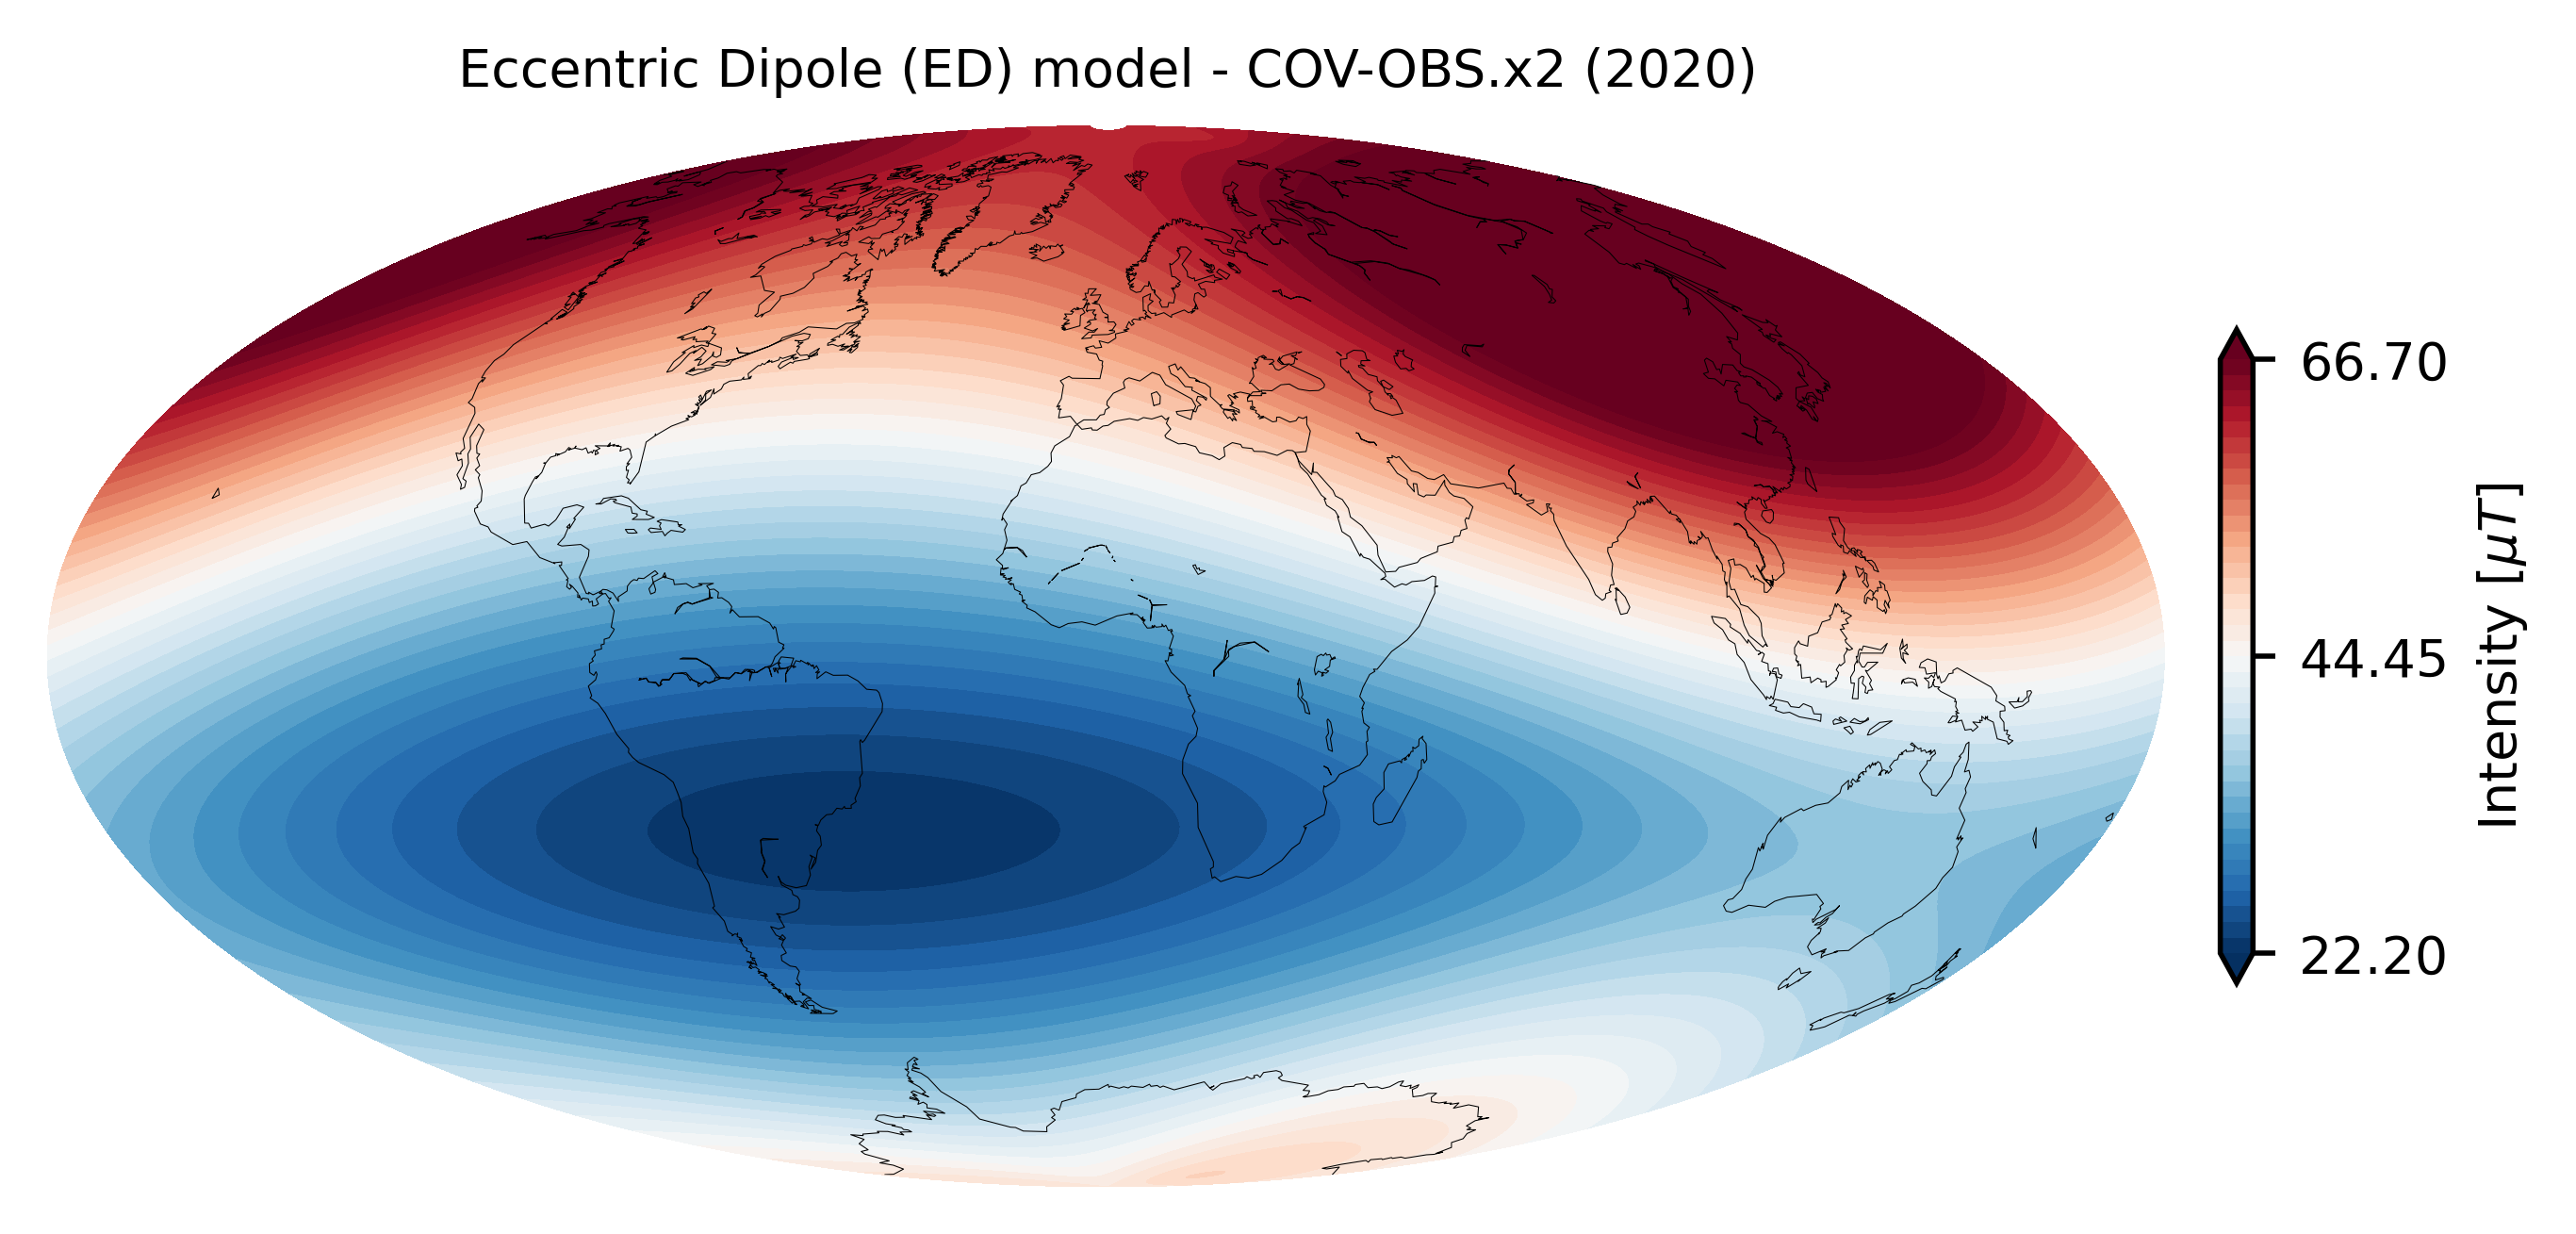

In [7]:
filepath = "C:/Users/Victor/Desktop/Simulacoes_Diversas/COV-OBS.x2/covobsx2.txt"

radius = 6371.2      # radius of our beautiful planet
lmax = 2             # the ED model only needs coefficients up to degree 2
target_year = 2020   # define the year based on the COV-OBS.x2 interval (1840 - 2020)

# defining the grid for our map
lon = np.arange(-180, 180, 1)
lat = np.arange(-90, 90, 1)
lon2d, lat2d = np.meshgrid(lon, lat)

def idx_lm(l, m):
    return sum((L + 1) for L in range(1, l)) + m

# function for readinf the Gauss coefficients in the covobsx2.txt file
def read_gauss_coeffs(filename, target_year, lmax=2):
    with open(filename, "r") as f:
        lines = f.readlines()
    years = list(map(float, lines[0].strip().split()))
    idx_year = years.index(float(target_year))
    coeff_lines = lines[1:]
    coeffs = [list(map(float, line.strip().split())) for line in coeff_lines]
    coeffs_at_year = [row[idx_year] for row in coeffs]
    gsh, hsh = [], []
    i = 0
    for l in range(1, lmax + 1):
        for m in range(0, l + 1):
            gsh.append(coeffs_at_year[i]); i += 1
            hsh.append(0.0 if m == 0 else coeffs_at_year[i])
            if m != 0:
                i += 1
    return np.array(gsh), np.array(hsh)

def F_ED_direct(lat_deg, lon_deg, gsh, hsh, RE=6371.2):
    def idx_lm(l, m):
        return sum((L + 1) for L in range(1, l)) + m
    
    # extracting the Gauss coefficients as they are organized in the covobsx2.txt file
    g10 = gsh[idx_lm(1,0)]
    g11 = gsh[idx_lm(1,1)]
    h11 = hsh[idx_lm(1,1)]
    g20 = gsh[idx_lm(2,0)]
    g21 = gsh[idx_lm(2,1)]
    g22 = gsh[idx_lm(2,2)]
    h21 = hsh[idx_lm(2,1)]
    h22 = hsh[idx_lm(2,2)]

    # definition of the variables
    L0 = 2*g10*g20 + np.sqrt(3.0)*(g11*g21 + h11*h21)
    L1 = -g11*g20 + np.sqrt(3.0)*(g10*g21 + g11*g22 + h11*h22)
    L2 = -h11*g20 + np.sqrt(3.0)*(g10*h21 - h11*g22 + g11*h22)

    # reference dipole amplitude
    B0 = np.sqrt(g10**2 + g11**2 + h11**2)

    E  = (L0*g10 + L1*g11 + L2*h11) / (4 * B0**2)

    # dimensionless quantities
    eps  = (L0 - g10*E) / (3 * B0**2)
    eta  = (L1 - g11*E) / (3 * B0**2)
    zeta = (L2 - h11*E) / (3 * B0**2)
    
    theta = np.radians(90 - lat_deg)              # colatitude of the CD model
    phi = np.radians(lon_deg)                     # longitude of the CD model
    
    px = radius*np.sin(theta)*np.cos(phi)         # x coordinate of P in CD model
    py = radius*np.sin(theta)*np.sin(phi)         # y coordinate of P in CD model
    pz = radius*np.cos(theta)                     # z coordinate of P in CD model
    
    dx, dy, dz = eta*RE, zeta*RE, eps*RE          # RE is the Earth's radius (common terminology in the papers dealing with the ED model)
    px_p, py_p, pz_p = px - dx, py - dy, pz - dz  # relationships between cartesian coordinates of P in ED and CD models

    # distance between the center of the ED and the point P at the CD (centered dipole) surface
    rprime = np.sqrt(px_p**2 + py_p**2 + pz_p**2)
    
    theta_p = np.arccos(pz_p / rprime)    # colatitude of P
    lat_p = 90 - theta_p                  # latitude of P

    # Intensity (F) calculated with the ED model (F_ed)
    F_ed = ((RE / rprime)**3 * g10 * np.sqrt(3*np.sin(lat_p)**2 + 1)) / 1000
    return np.abs(F_ed)


gsh, hsh = read_gauss_coeffs(filepath, target_year, lmax=lmax)
F_ed_map = np.zeros_like(lon2d, dtype=float)
for i in range(lat2d.shape[0]):
    for j in range(lat2d.shape[1]):
        F_ed_map[i, j] = F_ED_direct(lat2d[i, j], lon2d[i, j], gsh, hsh, RE=radius)

# figure settings
fig, ax = plt.subplots(figsize=(7, 6), dpi=500)
z = F_ed_map
m = Basemap(projection='hammer', lon_0=0, ax=ax)
x, y = m(lon2d, lat2d)

# ticks of the colorbar
w = np.linspace(22.20, 66.70, 39)
F_ticks = [22.20, 44.45, 66.70]

cs = ax.contourf(x, y, z, levels=w, cmap='RdBu_r', extend='both')
m.drawmapboundary(color='none', ax=ax)
m.drawcoastlines(color='black', linewidth=0.15, ax=ax)
ax.set_title(f"Eccentric Dipole (ED) model - COV-OBS.x2 ({target_year})", fontsize=8)

cl = plt.colorbar(cs, ax=ax, orientation="vertical", pad=0.02, shrink=0.3, ticks=F_ticks)
cl.ax.tick_params(labelsize=8, direction="out")
cl.set_label(r"Intensity [$\mu T$]", fontsize=8)

plt.show()